In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf
import statsmodels.api as sm


In [2]:
# upload data

file_path = '/Users/dominicprenovost/Programmation/TP1-PF-management/5_Industry_Portfolio.xlsx'
# Read the csv file into a dataframe 
df = pd.read_excel(file_path)

# Drop missing values
df.replace(-99.99, np.nan, inplace = True)
df.replace(-999, np.nan, inplace = True)
df.dropna(inplace = True)

# setting date as index 
df = df.set_index('Date')

rets = df/100 
# Sélectionnez les données entre décembre 2018 et décembre 2023
rets_5 = rets['2018-12-01':'2023-12-31']
rets_10 = rets['2013-12-01':'2023-12-31']

# Disp first row 
print(rets_5)
print(rets_10)


             Cnsmr   Manuf   HiTec   Hlth    Other
Date                                              
2018-12-01 -0.0988 -0.0906 -0.0823 -0.0825 -0.1094
2019-01-01  0.0810  0.0896  0.0870  0.0532  0.0980
2019-02-01  0.0109  0.0416  0.0539  0.0330  0.0296
2019-03-01  0.0285  0.0072  0.0332  0.0050 -0.0147
2019-04-01  0.0411  0.0243  0.0587 -0.0316  0.0663
...            ...     ...     ...     ...     ...
2023-08-01 -0.0182 -0.0182 -0.0158 -0.0022 -0.0335
2023-09-01 -0.0494 -0.0395 -0.0582 -0.0471 -0.0341
2023-10-01 -0.0343 -0.0305 -0.0168 -0.0458 -0.0253
2023-11-01  0.0788  0.0522  0.1165  0.0587  0.1041
2023-12-01  0.0548  0.0386  0.0456  0.0690  0.0654

[61 rows x 5 columns]
             Cnsmr   Manuf   HiTec   Hlth    Other
Date                                              
2013-12-01  0.0112  0.0288  0.0398  0.0062  0.0310
2014-01-01 -0.0595 -0.0410 -0.0193  0.0188 -0.0437
2014-02-01  0.0491  0.0510  0.0458  0.0648  0.0349
2014-03-01  0.0071  0.0145 -0.0045 -0.0256  0.0198
2014-04-

In [3]:
# Fonctions - Partie A


def exp_rets(returns, alpha, method='moyenne', arma_order=None):
    """
    Objectif
    ---------- 
    Estimer les rendements attendus de nos portefeuilles industriels
    
    Paramètres
    ----------
    returns : DataFrame
        DataFrame qui contient les rendements des différents portefeuilles industriels.
    alpha : float
        Facteur de lissage utilisé si la méthode est 'moyenne_exp_ponderee'.
    method : str, optional
        Méthode à utiliser pour l'estimation des rendements attendus. 
        Les options sont 'moyenne_historique' (par défaut), 'MME' (Moyenne Mobile Exponentielle) ou 'arma'.
    arma_order : tuple, optional
        Ordre du modèle ARMA à ajuster, par exemple, (1, 1) pour un modèle ARMA(1, 1).
    
    Sortie
    ------
    Un tableau avec les rendements attendus pour chaque portefeuille industriel.
    """
    
    if method == 'moyenne':
        z = np.array(returns.mean())
        
    elif method == 'MME':
        rendements_pond_exp = returns.ewm(span=1/alpha, adjust=False).mean()
        z = np.array(rendements_pond_exp.iloc[-1])
    
    elif method == 'arma' and arma_order:
        model = sm.tsa.ARMA(returns, order=arma_order)
        results = model.fit()
        z = results.predict(start=len(returns), end=len(returns), dynamic=False)

    # Ajouter d'autres méthodes si nécessaire
        
    # Annualiser le rendement 
    z = z * 12
    
    return z


def covariance_matrix(returns):
    """
    Objectif
    ---------- 
    Estimer la matrice de covariance de nos portefeuilles industriels
    
    Paramètres
    ----------
    returns : DataFrame
        DataFrame qui contient les rendements des différents portefeuilles industriels.

    Nous choisissons Ledoit-Wolf en raison d'un ensemble de données relativement petit avec de nombreux actifs 
    et nous voulons une méthode simple et efficace en termes de calcul pour réduire l'erreur d'estimation.
    """

    lw = LedoitWolf()
    lw.fit(returns)
    sigma = lw.covariance_
    
    # Covariance annualisée 
    sigma * 12
    
    return sigma

def efficient_frontier_Analytique(exp_ret, sigma, R_cible=0.10, rf=0.0044):
    """
    Optimisation de la frontière efficiente
    
    Paramètres:
    exp_ret : numpy array
        Matrice des rendements des actifs
    sigma : numpy array
        Matrice de covariance des rendements des actifs
    R_cible : float
        Rendement cible du portefeuille
    rf : float
        Taux sans risque
    
    Retours:
    Z_barre : numpy array
        Rendements attendus des actifs
    rendements_optimaux : numpy array
        Rendements optimaux pour la frontière efficiente
    rendement_optimal : float
        Rendement du portefeuille optimal
    volatilites_optimales : numpy array
        Volatilités optimales des portefeuilles pour la frontière efficiente
    rendements_optimaux_etendus : numpy array
        Rendements optimaux étendus pour la frontière complète
    volatilites_optimales_etendues : numpy array
        Volatilités optimales étendues des portefeuilles pour la frontière complète
    tangent_portfolio_return : float
        Rendement du portefeuille tangent
    tangent_portfolio_volatility : float
        Volatilité du portefeuille tangent
    CML_ret : numpy array
        Rendements attendus pour la ligne du marché des capitaux (CML)
    CML_std : numpy array
        Écarts types pour la ligne du marché des capitaux (CML)
    """

    Z_barre = exp_ret  # Rendements attendus des actifs
    ones = np.ones(len(Z_barre))  # Vecteur de uns

    # Inversion de la matrice de covariance
    Sigma_inv = np.linalg.inv(sigma)

    # Construction de la matrice A et du vecteur b
    A = np.array([
        [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
        [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
    ])

    b = np.array([1, R_cible])

    # Inversion de la matrice A
    A_inv = np.linalg.inv(A)

    # Résolution pour obtenir les multiplicateurs de Lagrange
    lambda_theta = np.dot(A_inv, b)

    # Calcul des poids optimaux du portefeuille
    w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

    # Intervalle des rendements cibles pour la frontière efficiente
    rendements_cibles_efficients = np.linspace(min(Z_barre), max(Z_barre), 100)

    # Calcul des volatilités et des rendements pour la frontière efficiente
    volatilites_optimales = []
    rendements_optimaux = []

    for R_cible in rendements_cibles_efficients:
        b = np.array([1, R_cible])
        lambda_theta = np.dot(A_inv, b)
        wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
        rendement_optimal = np.dot(wi_optimal, Z_barre)
        volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma, wi_optimal)))
        rendements_optimaux.append(rendement_optimal)
        volatilites_optimales.append(volatilite_optimale)

    # Étendre l'intervalle des rendements cibles pour la frontière complète
    rendements_cibles_etendus = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 200)

    # Calcul des volatilités et des rendements pour la frontière complète
    volatilites_optimales_etendues = []
    rendements_optimaux_etendus = []

    for R_cible in rendements_cibles_etendus:
        b = np.array([1, R_cible])
        lambda_theta = np.dot(A_inv, b)
        wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
        rendement_optimal = np.dot(wi_optimal, Z_barre)
        volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma, wi_optimal)))
        rendements_optimaux_etendus.append(rendement_optimal)
        volatilites_optimales_etendues.append(volatilite_optimale)

    # Calcul de la pente de la Ligne du Marché des Capitaux (CML)
    CML_slope = (max(rendements_optimaux) - rf) / max(volatilites_optimales)

    # Générer les écarts types pour la Ligne du Marché des Capitaux (CML)
    CML_std = np.linspace(0, max(volatilites_optimales), 100)

    # Calcul des rendements correspondants pour la Ligne du Marché des Capitaux (CML)
    CML_ret = rf + CML_slope * CML_std

    # Calcul des ratios de Sharpe pour tous les points de la frontière efficiente
    sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

    # Trouver l'indice du portefeuille avec le ratio de Sharpe maximal
    max_sharpe_index = np.argmax(sharpe_ratios)

    # Extraire le rendement et la volatilité du portefeuille tangent
    tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
    tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]

    return Z_barre, rendements_optimaux, rendement_optimal, volatilites_optimales, rendements_optimaux_etendus, volatilites_optimales_etendues, tangent_portfolio_return, tangent_portfolio_volatility, CML_ret, CML_std


def plot_efficient_frontier_a(ret_5, sigma, rf, include_CML=False):
    """
    Trace la frontière efficiente complète avec les portefeuilles industriels.
    
    Paramètres :
    ret_5 : numpy array
        Matrice des rendements des actifs
    sigma_5 : numpy array
        Matrice de covariance des rendements des actifs
    rf : float
        Taux sans risque
    include_CML : booléen, optionnel
        Indique s'il faut inclure la ligne du marché des capitaux (CML) dans le graphique. Par défaut, c'est True.
    """

    # Appel de la fonction efficient_frontier_optimization
    Z_barre, rendements_optimaux, rendement_optimal, volatilites_optimales, rendements_optimaux_etendus, volatilites_optimales_etendues, tangent_portfolio_return, tangent_portfolio_volatility, CML_ret, CML_std = efficient_frontier_Analytique(ret_5, sigma)

    
    if not include_CML:
        # Trace la frontière efficiente complète
        plt.figure(figsize=(10, 6))
        plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Locus des moyennes-variances', color='grey')
        plt.plot(volatilites_optimales, rendements_optimaux, label='Frontière efficiente', color='blue')
        plt.scatter(np.sqrt(np.diag(sigma)), Z_barre, color='red', label='Portefeuilles industriels')
        plt.title('Locus des moyennes-variances avec la frontière efficiente')
        plt.xlabel('Écart type (Volatilité)')
        plt.ylabel('Rendement attendu (Moyenne)')
        plt.legend()
        plt.grid(True)
        plt.xlim(0.03, 0.08)
        plt.ylim(0, 0.30)
        plt.show()    # Vérifie si la CML doit être incluse

    else:
        plt.figure(figsize=(10, 6))
        plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Locus des moyennes-variances', color='black')
        plt.plot(volatilites_optimales, rendements_optimaux, label='Frontière efficiente', color='blue')
        plt.plot(CML_std, CML_ret, label='Ligne du marché des capitaux', color='black', linestyle='--')
        plt.scatter(np.sqrt(np.diag(sigma)), Z_barre, color='red', label='Portefeuilles industriels')
        plt.scatter(tangent_portfolio_volatility, tangent_portfolio_return, color='blue', marker='o', s=100, label='Portefeuille tangent')
        plt.title('Locus des moyennes-variances avec la frontière efficiente')
        plt.xlabel('Écart type (Volatilité)')
        plt.ylabel('Rendement attendu (Moyenne)')
        plt.legend()
        plt.grid(True)
        plt.xlim(0.03, 0.08)
        plt.ylim(0, 0.30)
        
        plt.show()


def efficient_frontier_numerique(sim, z, sigma, rf, rf_asset=False):
    """
    Objectif
    ---------- 
    Obtenir les données pour tracer la frontière efficiente.
    
    Paramètres
    ----------
    z : Retour attendu sur chaque actif
    sigma : Matrice de covariance
    rf : Taux sans risque actuel (Billet du Trésor à 1 mois)
    rf_asset : Inclure l'actif sans risque ou non
    
    Sortie
    ------
    Volatilités et rendements pour tracer la frontière efficiente
    + Poids des actifs
    """
    
    target_returns = np.linspace(z.min()-0.1, z.max()+0.1, num=sim)

    efficient_portfolio_returns = []
    efficient_portfolio_volatilities = []
    weights = []
    
    for target_return in target_returns:
        if not rf_asset:
            w = cp.Variable(len(z))
            # Rendement du portefeuille
            portfolio_return = z @ w
            # Volatilité du portefeuille
            portfolio_volatility = w.T @ sigma @ w 
        else:
            w = cp.Variable(len(z) + 1)
            # Rendement du portefeuille
            z_rf = np.append(z, rf)
            portfolio_return = (z_rf - rf) @ w + rf
            # Volatilité du portefeuille
            portfolio_volatility = cp.quad_form(w[:-1], sigma) 
            
        # Contraintes du portefeuille
        contraintes = [cp.sum(w) == 1, portfolio_return == target_return]
        # Problème d'optimisation du portefeuille
        probleme = cp.Problem(cp.Minimize(portfolio_volatility), contraintes)
        # Résoudre le problème
        probleme.solve()
        # Stocker les résultats du portefeuille
        efficient_portfolio_returns.append(target_return)
        efficient_portfolio_volatilities.append(cp.sqrt(portfolio_volatility).value)
        weights.append(w.value)
 
    # Calculate minimum variance portfolio weights with short selling
    w_min_var_short = minimum_variance_portfolio(z, sigma)
    

    

    return efficient_portfolio_volatilities, efficient_portfolio_returns, weights

def minimum_variance_portfolio(z, sigma):
    """
    Calculate the minimum variance portfolio weights with short selling.

    Parameters
    ----------
    z : np.array
        Rendements attendus pour chaque actif.
    sigma : np.array
        Matrice de covariance.

    Returns
    -------
    np.array
        Poids du portefeuille minimisant la variance.
    """
    n = len(z)
    w = cp.Variable(n)
    portfolio_volatility = cp.quad_form(w, sigma)

    # Contraintes du portefeuille
    contraintes = [cp.sum(w) == 1]

    # Problème d'optimisation du portefeuille
    probleme = cp.Problem(cp.Minimize(portfolio_volatility), contraintes)

    # Résoudre le problème
    probleme.solve()

    return w.value           
        
    

def plot_efficient_frontier2(z, sigma, sim, rf, rf_asset=False):
    """
    Fonction pour tracer la frontière efficiente moyenne-variance avec les actifs individuels et le portefeuille tangent.

    Paramètres
    ----------
    z : np.array
        Rendements attendus pour chaque actif.
    sigma : np.array
        Matrice de covariance.
    sim : int
        Nombre de simulations.
    rf : float
        Taux sans risque.
    rf_asset : bool, facultatif
        Inclure l'actif sans risque, par défaut False.

    Renvoie
    -------
    None
    """
    # Appeler la fonction efficient_frontier_numerique pour obtenir les données pour tracer la frontière efficiente
    volatilities, returns,_ = efficient_frontier_numerique(sim, z, sigma, rf, rf_asset=False)

    # Calculate minimum variance portfolio
    w_min_var = minimum_variance_portfolio(z, sigma)
    min_var_portfolio_return = np.dot(z, w_min_var)
    min_var_portfolio_volatility = np.sqrt(np.dot(w_min_var, np.dot(sigma, w_min_var)))
    
    # Créer une figure
    plt.figure(figsize=(10, 6))

    # Tracer la frontière efficiente avec rf_asset=False
    plt.plot(volatilities, returns, label='Frontière Efficient (RF=False)', linestyle='-', linewidth=2.5, color='blue')
    
    # Tracer les actifs individuels
    plt.scatter(np.sqrt(np.diag(sigma)), z, color='red', label='Actifs Individuels', marker='o')

    # Tracer la frontière efficiente avec rf_asset=True
    if rf_asset:
        volatilities_rf, returns_rf, _ = efficient_frontier_numerique(sim, z, sigma, rf, rf_asset=True)
        plt.plot(volatilities_rf, returns_rf, label='Frontière Efficient (RF=True)', linestyle='--', color='green', linewidth=2.5)

    # Highlight minimum variance portfolio
    plt.scatter(min_var_portfolio_volatility, min_var_portfolio_return, color='red', label='Minimum Variance Portfolio', marker='o', s=150, edgecolors='black', linewidth=2)
 

    plt.xlim(0.03, 0.08)
    plt.ylim(0, 0.30)
    # Ajouter les étiquettes et le titre
    plt.xlabel('Volatilité du Portefeuille')
    plt.ylabel('Rendement du Portefeuille')
    plt.title('Frontière Efficient avec les Actifs Individuels')
    plt.legend()
    plt.show()

# Analytique bon code

In [11]:
def bootstrap_A(ret, R_cible, rf, methode_moy, N_boot, cov_lw=True, include_CML=False):
    num_bootstrap_samples = N_boot
    all_volatilities = []
    all_returns = []
    all_tangent_portfolio_weights = []
    all_tangent_portfolio_means = []
    all_tangent_portfolio_variances = []
    all_tangent_portfolio_sharpe_ratios = []
    
    for _ in range(num_bootstrap_samples):
        sample = ret.sample(n=len(ret), replace=True)
        ret_moy = exp_rets(sample, 0.3, method=methode_moy)
        
        if cov_lw:
            sigma_boot = covariance_matrix(sample)
        else:
            sigma_boot = np.cov(sample, rowvar=False) * 12
        ones = np.ones(len(ret_moy))  
        Sigma_inv = np.linalg.inv(sigma_boot)

        A = np.array([
            [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, ret_moy))],
            [np.dot(ret_moy, np.dot(Sigma_inv, ones)), np.dot(ret_moy, np.dot(Sigma_inv, ret_moy))]
        ])
        b = np.array([1, R_cible])
        A_inv = np.linalg.inv(A)

        rendements_cibles_etendus = np.linspace(min(ret_moy) - 0.015, max(ret_moy) + 0.015, 200)
        volatilites_optimales_etendues = []
        rendements_optimaux_etendus = []
        for R_cible in rendements_cibles_etendus:
            b = np.array([1, R_cible])
            lambda_theta = np.dot(A_inv, b)
            wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, ret_moy)
            rendement_optimal = np.dot(wi_optimal, ret_moy)
            volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_boot, wi_optimal)))
            rendements_optimaux_etendus.append(rendement_optimal)
            volatilites_optimales_etendues.append(volatilite_optimale)

        all_volatilities.append(volatilites_optimales_etendues)
        all_returns.append(rendements_optimaux_etendus)

        # Calculate tangent portfolio weights, means, and variances
        tangent_portfolio_weights = np.linalg.inv(sigma_boot) @ (ret_moy - rf*ones) / (A[0, 1] - A[0, 0] * rf)
        tangent_portfolio_return = np.dot(tangent_portfolio_weights, ret_moy)
        tangent_portfolio_variance = np.dot(tangent_portfolio_weights.T, np.dot(sigma_boot, tangent_portfolio_weights))

        all_tangent_portfolio_weights.append(tangent_portfolio_weights)
        all_tangent_portfolio_means.append(tangent_portfolio_return)
        all_tangent_portfolio_variances.append(tangent_portfolio_variance)

        # Calculate Sharpe ratio for the tangent portfolio
        tangent_portfolio_sharpe_ratio = (tangent_portfolio_return - rf * 12) / np.sqrt(tangent_portfolio_variance)
        all_tangent_portfolio_sharpe_ratios.append(tangent_portfolio_sharpe_ratio)
        max_sharpe_tangent_portfolio_index = np.argmax(all_tangent_portfolio_sharpe_ratios)
        
        
        tangent_weights = all_tangent_portfolio_weights[max_sharpe_tangent_portfolio_index]
        mean_tangent_returns = np.mean(all_tangent_portfolio_means)
        mean_tangent_var = np.mean(all_tangent_portfolio_variances)
        mean_tangent_sharpe = np.mean(all_tangent_portfolio_sharpe_ratios)

    if not include_CML:
        plt.figure(figsize=(10, 6))
        for volatilities, returns in zip(all_volatilities, all_returns):
            plt.plot(volatilities, returns, 'b-', alpha=0.3)

        plt.title('Mean-Variance Locus with Efficient Frontier (100 Bootstraps)')
        plt.xlabel('Volatility')
        plt.ylabel('Expected Return')
        plt.show()

    else:
        plt.figure(figsize=(10, 6))
        for volatilities, returns in zip(all_volatilities, all_returns):
            plt.plot(volatilities, returns, color='blue', alpha=0.4)  # Alpha for transparency
            CML_slope = (max(returns) - rf) / max(volatilities)
            CML_std = np.linspace(0, max(volatilities), 100)
            CML_ret = rf + CML_slope * CML_std
            plt.plot(CML_std, CML_ret, label='Capital Market Line', color='black', linestyle='--')

        plt.title('Mean-Variance Locus with Efficient Frontier and CML (100 Bootstraps)')
        plt.xlabel('Standard Deviation (Volatility)')
        plt.ylabel('Expected Return (Mean)')
        plt.xlim(0)
        plt.show()
        
    return (f"Tangent weights: {tangent_weights}", 
            f"Mean tangent returns: {mean_tangent_returns}", 
            f"Mean tangent variance: {mean_tangent_var}", 
            f"Mean tangent Sharpe ratio: {mean_tangent_sharpe}")


### Modèle Centrale - Moyenne historique - Cov standard

Premièrement, nous avons évalué nos 100 échantillon bootstraps avec le modèle qu'on appelle standard. Pour ce modèle, nous utilisons la moyenne historique et calculons la matrice de variance-covariance avec la fonction Numpy tout simplement. Nous avons utilisé un rendement cible "mu" de 10% et un taux sans risque mensuel de 0.44%.

In [ ]:
bootstrap_A(rets_5, 0.10, 0.0044, 'moyenne', 100, cov_lw=False, include_CML=False)

En testant ce modèle, nous remarquons que l’apprcoche de Markowitz est très sensible au changement de paramètres. Une petite variation dans les paramètres peut conduire à des changements significatifs dans la construction de la frontière efficiente.

En termes de rendements espérés annuels, la majorité des frontières se trouvent entre 0 et 20%. Pour ce qui est de la volatilité des portefeuilles, elle se trouve entre 12% et 24%. À première vue, les résultats semblent pas aussi irréaliste qu'on aurait pu le croire, mais lorsque l'on regarde la moyenne des statistiques descriptives des portefeuilles de tangeante, les résultats deviennent plutôt irréalistes. La moyenne des rendements annuels de nos portefeuilles de tangeante est de 1.25%, une variance de 305%, ce qui donne une écart-type d'envrion 17.50% et le ratio de Sharpe moyen est de 2.75.

### Test avec différente cov et moyenne

Maitenant, nous nous sommes demandés est-ce que les résultats seraient plus intéressants si on calculait les estimateurs de façon plus scientifique.

In [ ]:
bootstrap_A(rets_5, 0.10, 0.0044, 'MME', 100, cov_lw=False, include_CML=False)

Premièrement, au lieu de prendre la moyenne historique, nous avons testé avec la moyenne mobile exponentielle et un degré de lissage de 0.3. Ici la volatilité reste pareil, mais les rendements espérés annuels ont grandement augmenté, passant de -100% à 100%. Pour tous les portefeuilles de tangeantes de nos échantillons, nous avons une moyenne de rendement de -1.68%, une variance de 4.68% et un ratio de Sharpe moyen de -1.42.

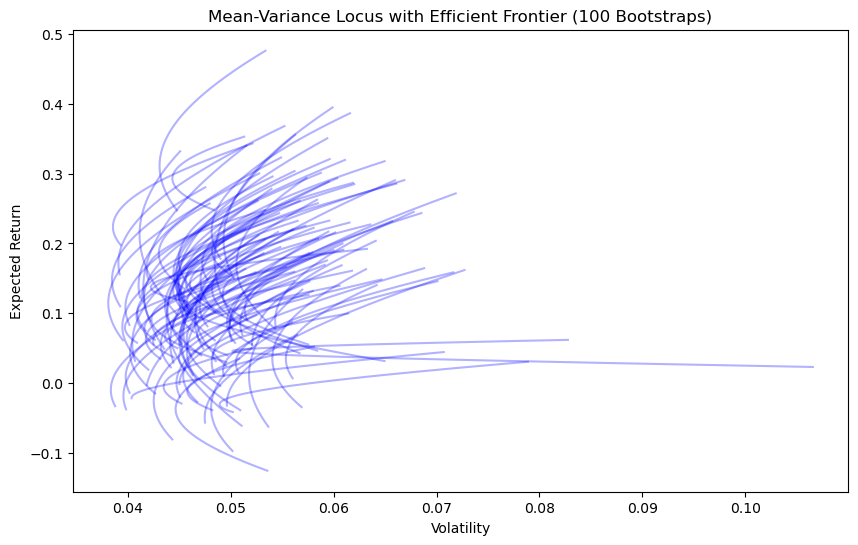

('Tangent weights: [ 0.45347125 -0.1101193   0.85094039  0.03099156 -0.2252839 ]',
 'Mean tangent returns: 0.3961952982434335',
 'Mean tangent variance: 0.15500268943681358',
 'Mean tangent Sharpe ratio: 2.8775305969040437')

In [18]:
bootstrap_A(rets_5, 0.10, 0.0044, 'moyenne', 100, cov_lw=True, include_CML=False)

Deuxièmement, au lieu de prendre calculer la matrice de variance-covariance avec la fonction de Numpy, nous l'avons calculé avec la méthode Ledoit-Wolf. Ici nous utilisons la moyenne historique pour les rendements espérés. La méthode Ledoit-Wolf fait que la volatilité est beaucoup trop petite. Pour nos portefeuille de tangeante, la moyenne des rendements espérés est à 1.06%, avec une variance de 1.48, ce qui donne un ratio de Sharpe moyen de 10.6.

In [ ]:
bootstrap_A(rets_5, 0.10, 0.0044, 'MME', 100, cov_lw=True, include_CML=False)

Troisièmement, nous avons testé les deux méthodes précédentes ensemble. Donc la moyenne des rendements est une moyenne mobile exponentielle avec un facteur de lissage de 0.3 et nous calculons la matrice de variance-covariance avec la méthode Ledoit-Wolf. Ici les problèmes des 2 méthodes se combinent. Les rendements espérés annuels sont très élevé et la volatilité très basses. La moyenne des rendements de nos portefeuilles de tangeante est de pratiquement 0, la variance est de 0.25% et le ratio de Shapre moyen serait de 15.37.

Nous concluons que l'utilisation des méthodes plus scientifiques pour calculer nos estimateurs, n'est pas une solution au problème de sensibilité des estimateurs de l'approche de Markowitz

# numérique

In [ ]:
def bootstrap_N(ret, R_cible, rf, methode_moy, N_boot, cov_lw=True, include_CML=False):
    num_bootstrap_samples = N_boot
    all_volatilities = []
    all_returns = []
    tangent_weights_list = []
    tangent_var_list = []
    tangent_ret_list = []
    sharpe_ratio_list = []
    
    for _ in range(num_bootstrap_samples):
        sample = ret.sample(n=len(ret), replace=True)
        ret_moy = exp_rets(sample, 0.94, method=methode_moy)
        
        if cov_lw:
            sigma_boot = covariance_matrix(sample)
        else:
            sigma_boot = np.cov(sample, rowvar=False) * 12
        ones = np.ones(len(ret_moy))
        
        # Fonction objectif : Variance du portefeuille
        def minportfolio_variance(W, sigma_boot):
            return W.T @ (sigma_boot @ W)
        
        # Fonction objectif : Négatif du ratio de Sharpe
        def negativeSR(w, sigma_boot):
            R = np.sum(ret_moy * w)
            V = np.sqrt(np.dot(w.T, np.dot(sigma_boot, w)))
            SR = R / V
            return -SR

    
        # Poids initiaux : répartition uniforme
        W = np.ones(len(ret_moy)) * (1.0 / len(ret_moy))
        
        # Fonction d'optimisation
        def optimize(func, W, sigma_boot, target_return):
            # Contraintes
            opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # Somme des poids égale à 1
                               {'type': 'eq', 'fun': lambda W: W.T @ ret_moy - target_return},  # Rendement attendu égal à rendement cible
                               {'type': 'ineq', 'fun': lambda W: W})  # Pas de vente à découvert

            # Optimisation
            optimal_weights = minimize(func, W, args=(sigma_boot), method='trust-constr', constraints=opt_constraints)

            return optimal_weights.x
    
# Générer une série de rendements cibles
        rendements_cibles = np.linspace(min(ret_moy) - 0.015, max(ret_moy) + 0.015, 100)

        # Initialiser les listes pour stocker les volatilités et rendements optimaux
        volatilites_optimales = []
        rendements_optimaux = []

        # Itérer sur les rendements cibles pour optimiser les poids du portefeuille
        for R_cible in rendements_cibles:
            W = np.ones(len(ret_moy)) * (1.0 / len(ret_moy))  # Réinitialiser les poids initiaux pour chaque itération
            poids_optimaux = optimize(minportfolio_variance, W, sigma_boot, R_cible)
            var_optimale = minportfolio_variance(poids_optimaux, sigma_boot)
            rendement_optimal = np.dot(poids_optimaux, ret_moy)

            volatilites_optimales.append(np.sqrt(var_optimale))
            rendements_optimaux.append(rendement_optimal)
            
        # Store data for efficient frontier
        all_volatilities.append(volatilites_optimales)
        all_returns.append(rendements_optimaux)
        
        tangent_weights = optimize(negativeSR, W, sigma_boot, R_cible)
        tangent_var = np.dot(tangent_weights.T, np.dot(sigma_boot, tangent_weights))
        tangent_ret = np.dot(tangent_weights, ret_moy)
        tangent_sharpe_ratio = (tangent_ret - rf) / np.sqrt(tangent_var)
        max_tangent_sharpe_ratio = np.argmax(tangent_sharpe_ratio)
        
         # Stockez les valeurs dans les listes
        tangent_weights_list.append(tangent_weights)
        tangent_var_list.append(tangent_var)
        tangent_ret_list.append(tangent_ret)
        sharpe_ratio_list.append(tangent_sharpe_ratio)
        
        tangent_weights_max_SR = tangent_weights_list[max_tangent_sharpe_ratio]
        mean_tangent_returns = np.mean(tangent_ret_list)
        mean_tangent_var = np.mean(tangent_var_list)
        mean_tangent_sharpe = np.mean(sharpe_ratio_list) * np.sqrt(12)
        
    if not include_CML:
        plt.figure(figsize=(10, 6))
        for volatilities, returns in zip(all_volatilities, all_returns):
            plt.plot(volatilities, returns, 'b-', alpha=0.3)

        plt.xlabel('Volatility')
        plt.ylabel('Expected Return')
        plt.title('Efficient Frontier and Tangent Portfolio')
        plt.show()

    else:
        plt.figure(figsize=(10, 6))
        for volatilities, returns in zip(all_volatilities, all_returns):
            plt.plot(volatilities, returns, color='blue', alpha=0.4)  # Alpha for transparency
            CML_slope = (max(returns) - rf) / max(volatilities)
            CML_std = np.linspace(0, max(volatilities), 100)
            CML_ret = rf + CML_slope * CML_std
            plt.plot(CML_std, CML_ret, label='Capital Market Line', color='black', linestyle='--')

        plt.title('Mean-Variance Locus with Efficient Frontier and CML (100 Bootstraps)')
        plt.xlabel('Standard Deviation (Volatility)')
        plt.ylabel('Expected Return (Mean)')
        plt.xlim(0)
        plt.show()
        
    return(f"Tangent weights: {tangent_weights_max_SR}", 
        f"Mean tangent returns: {mean_tangent_returns}", 
        f"Mean tangent variance: {mean_tangent_var}", 
        f"Mean tangent Sharpe ratio: {mean_tangent_sharpe}")
